In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
#Reading in service episodes raw csv using pandas and changing some datatypes
ser = pd.read_csv('service_episode_raw.csv')
ser[['ClientID', 'ServiceEpisodeID']] = ser[['ClientID', 'ServiceEpisodeID']].astype(str)
ser['Created At'] =  pd.to_datetime(ser['Created At'], format='%m/%d/%Y %H:%M')

In [63]:
#Reading in the lookup table of organizations and their county, state and zipcodes
orgs_lookup_table = pd.read_csv('orgs.csv')

This lookup_table houses the information needed to fill in empty data points for the clients. Some of the clients have missing state, county and zip code information. Using this lookup_table, based on the organization that the client presented their need to, allows us to have an accurate picture of their address information.

In [64]:
#Replacing all NaN state values in service episode raw by looking up the organization states from orgs_lookup_table
ser['Address 1 State']=np.where(ser['Address 1 State'].isnull(),ser['Originating Organization'].map(orgs_lookup_table.set_index('OrganizationID').State),ser['Address 1 State'])

#Replacing all NaN county values in service episode raw by looking up the organization county from orgs_lookup_table
ser['Address 1 County']=np.where(ser['Address 1 County'].isnull(),ser['Originating Organization'].map(orgs_lookup_table.set_index('OrganizationID').County),ser['Address 1 County'])

In [65]:
#Finding and cleaning the 9-digit zipcodes. We want to truncate them to 5-digits
long_zip_codes = ser['Address 1 Postal Code'].str.len() > 5
print(ser['Address 1 Postal Code'][long_zip_codes].unique())
ser['Address 1 Postal Code'] = ser['Address 1 Postal Code'].str.slice(0, 5)

['40218-5250' '40110-0100' '40272-2587' '40219-4832' '40071-9602'
 '40220-0000' '40228-2016' '40129-0035' '40219-2252' '40215-1496'
 '40212-2927' '40258-4108']


In [66]:
#Replacing all NaN zipcode values in service episode raw by looking up the organization zipcode from orgs_lookup_table
ser['Address 1 Postal Code']=np.where(ser['Address 1 Postal Code'].isnull(),ser['Originating Organization'].map(orgs_lookup_table.set_index('OrganizationID').ZipCode),ser['Address 1 Postal Code'])

In [67]:
#Creating new csv in project folder of cleaned service episode raw data
ser.to_csv(r'ser_cleaned.csv', index = False)

ser_cleaned = pd.read_csv('ser_cleaned.csv')

In [68]:
#Finding the service types with the most service episodes(aka touchpoints)
ser_cleaned_by_top_need = ser_cleaned.groupby('Service Type', as_index=False,)['ServiceEpisodeID'].nunique().sort_values(['ServiceEpisodeID'])

print(ser_cleaned_by_top_need)

AttributeError: 'DataFrameGroupBy' object has no attribute 'mode'

I wanted to understand what the top needs were in the community.

In [ ]:
#Finding which client needed the most help and had the most service episodes
print("Client ID", ser_cleaned['ClientID'].value_counts().idxmax(), "had the most service episodes")


Client ID 336 had the most service episodes


I also wanted to understand which client sought help the most. This helps me to know who needs priority when following up.

In [ ]:
#Finding which day of the month had the most service episodes
print(ser_cleaned['Created At'].value_counts())

2022-06-07 21:16:00    28
2022-06-16 15:33:00    11
2022-06-13 14:57:00    10
2022-06-09 20:22:00    10
2022-06-30 17:13:00    10
                       ..
2022-06-09 13:20:00     1
2022-06-21 13:08:00     1
2022-06-30 13:00:00     1
2022-06-21 18:44:00     1
2022-06-24 15:52:00     1
Name: Created At, Length: 2689, dtype: int64


This is the first step in being able to forecast. By seeing which date had the most service episodes.

In [ ]:
#Finding the number of unique clients by clientID
unique_clients = len(pd.unique(ser_cleaned['ClientID']))
print("There are", unique_clients, "unique clients")

There are 1106 unique clients


There was some duplication in the dataset, in order to calculate the averages correctly, I wanted to get rid of the duplicate values first. 

In [ ]:
#Dropping duplicate ages of duplicate clients so we can perform an average formula
ser_unique_clients = ser_cleaned.drop_duplicates(subset = ['ClientID', 'Age'], keep='first')

In [ ]:
#Calculating the average age of the unique clients
print("The average age of a client is", round(ser_unique_clients.Age.mean()), "years old")

The average age of a client is 40 years old


In [ ]:
#Average number of touchpoints(service episodes) per unique client
unique_service_epi = len(pd.unique(ser_cleaned['ServiceEpisodeID']))
ser_per_client = round(unique_service_epi/unique_clients)
print("There are", unique_service_epi, "unique service episodes, with an average of" , ser_per_client, "service episodes per client")

There are 2209 unique service episodes, with an average of 2 service episodes per client


In [ ]:
#Percentage of clients by gender
ser_unique_genders = ser_unique_clients['Gender'].value_counts()

ser_unique_genders_male = ser_unique_genders['Male']
percent_male = round((ser_unique_genders_male/unique_clients)*100)
print((round((ser_unique_genders_male/unique_clients)*100)), "percent of the clients are male")

ser_unique_genders_female = ser_unique_genders['Female']
percent_female = round((ser_unique_genders_female/unique_clients)*100)
print((round((ser_unique_genders_female/unique_clients)*100)), "percent of the clients are female")

ser_unique_genders_other = unique_clients - ser_unique_genders_female - ser_unique_genders_male
percent_other = round((ser_unique_genders_other/unique_clients)*100)
print((round((ser_unique_genders_other/unique_clients)*100)), "percent of the clients are other/non-binary")

22 percent of the clients are male
44 percent of the clients are female
35 percent of the clients are other/non-binary


In [ ]:
#Percentage of clients for Jefferson County
ser_counties = ser_unique_clients['Address 1 County'].value_counts()
print((round((ser_counties['Jefferson County']/unique_clients)*100)), "percent of the clients come from Jefferson County")

71 percent of the clients come from Jefferson County


In [ ]:
#Zipcode with the highest count of clients
highest_zipcode = ser_unique_clients['Address 1 Postal Code'].value_counts()
print(highest_zipcode)

40202.0    87
40211.0    74
47150.0    60
40210.0    59
40203.0    56
           ..
42131.0     1
40361.0     1
42141.0     1
41075.0     1
42345.0     1
Name: Address 1 Postal Code, Length: 144, dtype: int64


This allows us to get more granular with the data by being able to target which zipcodes the clients are coming from. This will let us know, when it comes time to fund organizations, which organizations we can fund that are in the zipcodes where we can reach the most clients.

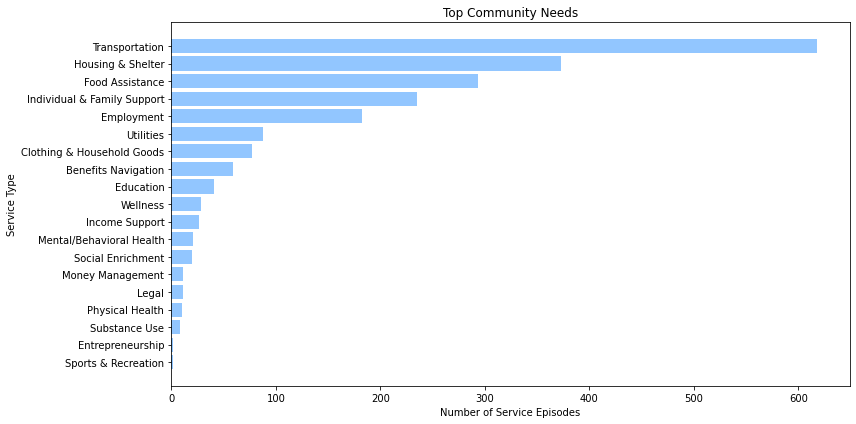

In [ ]:
#Plotting the highest needs by service episode volume
plt.style.use('seaborn-pastel')
plt.figure(figsize= (12,6))
plt.barh('Service Type', 'ServiceEpisodeID', data = ser_cleaned_by_top_need)
plt.ylabel('Service Type')
plt.xlabel('Number of Service Episodes')
plt.title('Top Community Needs')
plt.tight_layout()
plt.show()

This bar chart gives us a visual of the top needs in the community based on touchpoints.

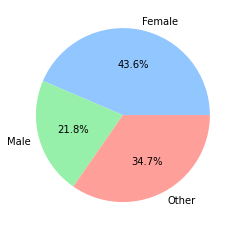

In [ ]:
#Plotting the gender makeup of the clients
plt.style.use('seaborn-pastel')
pie_chart_data = [percent_female, percent_male, percent_other]
plt.pie(pie_chart_data, labels = ['Female', 'Male', 'Other'], autopct='%1.1f%%')
plt.show()

This pie chart shows us the gender makeup of the clients seeking services.